In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
len(dataset)
img, label = dataset[0]
print(img.shape, label)

torch.Size([1, 28, 28]) 5


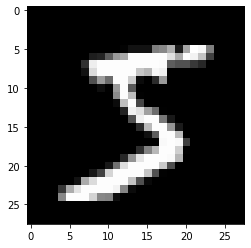

In [5]:
#displaying the image
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img[0], cmap='gray') #pyplot expects the channel to be at the end so img[0] does that


In [6]:
#this function just creates training and validation data indices
# received total length of dataset and percentage of data that will be in validation set
def split_indices(n, val_pct): 
    n_val = int(val_pct * n) # 60000 * .2 = 12000
    idxs = np.random.permutation(n) # creates a permutation of n numbers i.e 60000
    return idxs[n_val:], idxs[:n_val] # training data gets [12000: end] 
                                      # validation data gets [start: 12000] 
                                      # from a permutation of n

In [7]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])

48000 12000
Sample val indices:  [12307 30046 54922  3062 26402 58943 35769 30260 50995 37979 22290 40725
 44102 23627 46602 31204 22459 42310 57021 49052]


In [8]:
# now we need data to be loaded according to the training and validation indicies

batch_size = 100

#creating training sampler and training dataloader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)



#creating validation sampler and validation dataloader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset, batch_size, sampler=valid_sampler)

# ***Creating the MODEL***

In [9]:
import torch.nn.functional as F
import torch.nn as nn

In [10]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
        
        
    def forward(self, xb):
        #Flattening the image tensors
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        
        out = F.relu(out)
        out = self.linear2(out)
        
        return out

In [11]:
input_size = 784
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size= num_classes) #this one uses the super constructor function


In [12]:
for t in model.parameters():
    print(t.shape)

# it is stored in transpose form row becomes columns

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [13]:
for images, labels in train_dl:
    print('images.shape ', images.shape)
    outputs = model(images) #this one is calling the forward function with a batch of data
    loss = F.cross_entropy(outputs, labels)
    print('Loss:-', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
    
    

images.shape  torch.Size([100, 1, 28, 28])
Loss:- 2.3249289989471436
outputs.shape :  torch.Size([100, 10])
Sample outputs :
 tensor([[-0.3274, -0.0533, -0.1728,  0.0590, -0.1703, -0.0429, -0.0899,  0.1573,
          0.1217,  0.1853],
        [-0.1665, -0.1434, -0.1744,  0.1309, -0.1303,  0.0157, -0.0302,  0.0915,
          0.2020,  0.1774]])


# ****USING THE GPU****

In [14]:
torch.cuda.is_available()

True

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    
    return data.to(device, non_blocking=True)

In [18]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [19]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [21]:
for xb, yb in valid_dl:
    print('xb.device: ', xb.device)
    print('yb.device: ', yb.device)
    break
    

xb.device:  cuda:0
yb.device:  cuda:0


In [22]:
#loss batch function calculates loss, metric and perfomrs gradient descent if optimizer is given

def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #generate predictions
    preds = model(xb)
    #calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #gradient calculation
        loss.backward()
        #update  parameters
        opt.step()
        #set gradients to zero
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        #metric calculation
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result
        

In [23]:
# evaluate function

def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb, yb, in valid_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
            
    return avg_loss, total, avg_metric

In [24]:
# fit function has the training loop
# takes epochs learning rate 
def fit(epochs, lr, model, loss_fn, train_dl, 
        valid_dl, metric=None, opt_fn=None):
    losses, metrics = [], []
    
    if opt_fn is None: 
        opt_fn = torch.optim.SGD
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)
            
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        losses.append(val_loss)
        metrics.append(val_metric)
        
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}' 
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}' 
                  .format(epoch+1, epochs, val_loss,
                         metric.__name__, val_metric))
    return losses, metrics
     
        

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [26]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:4f}' .format(val_loss, val_acc))

Loss: 2.3232, Accuracy: 0.111500


In [28]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy, 
                        train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.2274, accuracy: 0.9309
Epoch [2/5], Loss: 0.1823, accuracy: 0.9447
Epoch [3/5], Loss: 0.1641, accuracy: 0.9515
Epoch [4/5], Loss: 0.1551, accuracy: 0.9541
Epoch [5/5], Loss: 0.1585, accuracy: 0.9544


In [29]:
losses2, metrics2 = fit(5, 0.1, model, F.cross_entropy, 
                        train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.1300, accuracy: 0.9631
Epoch [2/5], Loss: 0.1296, accuracy: 0.9633
Epoch [3/5], Loss: 0.1276, accuracy: 0.9637
Epoch [4/5], Loss: 0.1314, accuracy: 0.9630
Epoch [5/5], Loss: 0.1272, accuracy: 0.9640


In [30]:
losses3, metrics3 = fit(5, 0.000001, model, F.cross_entropy, 
                        train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.1272, accuracy: 0.9640
Epoch [2/5], Loss: 0.1272, accuracy: 0.9640
Epoch [3/5], Loss: 0.1272, accuracy: 0.9640
Epoch [4/5], Loss: 0.1272, accuracy: 0.9640
Epoch [5/5], Loss: 0.1272, accuracy: 0.9640


In [31]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'ACCURACY VS #ofEPOCHS')

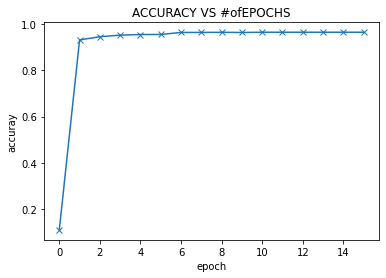

In [32]:
accuracies = [val_acc] + metrics1 + metrics2 + metrics3 

plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuray')
plt.title("ACCURACY VS #ofEPOCHS")